<a href="https://colab.research.google.com/github/GemmaGorey/Dissertation/blob/main/Similarity_Analysis_Audio_vs_Lyrics_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()
# install mamba to use instead of pip

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:06
🔁 Restarting kernel...


In [1]:
# Create the config file and build the environment.
yaml_content = """
name: dissertation
channels:
  - pytorch
  - conda-forge
dependencies:
  - python=3.11
  - pytorch=2.2.2
  - torchvision=0.17.2
  - torchaudio
  - librosa
  - numpy<2
  - pandas
  - jupyter
  - wandb
"""

# Write the string content to a file -  'environment.yml'.
with open('environment.yml', 'w') as f:
    f.write(yaml_content)

print("environment.yml file created successfully.")

# create the environment using mamba from the yml file.
print("\n Creating environment")

!mamba env create -f environment.yml --quiet && echo -e "\n 'dissertation' environment is ready to use."

environment.yml file created successfully.

 Creating environment
Channels:
 - pytorch
 - conda-forge
Platform: linux-64
Solving environment: ...working... done
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

 'dissertation' environment is ready to use.


In [2]:
# imports and setting up of GitHub and W&B

# clone project repository from GitHub
print("⏳ Cloning GitHub repository...")
!git clone https://github.com/GemmaGorey/Dissertation.git
print("Repository cloned.")

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#imports
import pandas as pd
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from transformers import AutoTokenizer
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoModel
import torch.optim as optim
import wandb
import subprocess

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') #loading the tokenizer for lyrics processing
print("Tokenizer loaded.")

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
import types
import json

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

⏳ Cloning GitHub repository...
Cloning into 'Dissertation'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 349 (delta 123), reused 77 (delta 66), pack-reused 181 (from 2)
Receiving objects: 100% (349/349), 3.17 MiB | 29.28 MiB/s, done.
Resolving deltas: 100% (180/180), done.
Repository cloned.
Mounted at /content/drive
Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded.


In [3]:
class MER_Dataset(Dataset):
    """ Custom PyTorch Dataset for loading MER data. """
    def __init__(self, annotations_df, tokenizer):
        """ Creation of the Dataset from the dataframe (predefined splits in MERGE dataset) """
        self.annotations = annotations_df
        self.tokenizer = tokenizer

    def __len__(self):
        """
        Function to return the total number of songs in the dataset.
        """
        return len(self.annotations)

    def __getitem__(self, index):
        """
        Function to get a song from the dataset.
        """
        song_info = self.annotations.iloc[index] #which song ID/row is picked from the dataset as per the index

        spectrogram_path = song_info['spectrogram_path'] # columns from the df
        lyrics_path = song_info['lyrics_path'] # columns from the df
        valence = song_info['valence'] # columns from the df
        arousal = song_info['arousal'] # columns from the df

        #change spectorgram into a tensor
        spectrogram = np.load(spectrogram_path) #loading spectorgram from path saved in df
        spectrogram_tensor = torch.from_numpy(spectrogram).float() # changing the np array to tensor
        spectrogram_tensor = spectrogram_tensor.unsqueeze(0) #Adding a "channel" dimension for CNN

        #Load the lyric tokens
        encoded_lyrics = torch.load(lyrics_path, weights_only=False)
        input_ids = encoded_lyrics['input_ids'].squeeze(0) #remove the batch dimension from input ids so 1d array
        attention_mask = encoded_lyrics['attention_mask'].squeeze(0) #remove the batch dimension from attention mask so 1d

        labels = torch.tensor([valence, arousal], dtype=torch.float32) # extract labels

        return spectrogram_tensor, input_ids, attention_mask, labels

In [4]:
class AttentionModule(nn.Module): #Addition from V1
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        '''
        Attention mechanism to weight the importance of different features
        '''
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 4),  # input is 64 will map to16
            nn.ReLU(),
            nn.Linear(feature_dim // 4, feature_dim),  #reverts back to 64 from 16
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: [batch_size, 64]
        attention_weights = self.attention(x)  # [batch_size, 64]
        weighted_features = x * attention_weights  # Element-wise multiplication
        return weighted_features

In [5]:
class VGGish_Audio_Model(nn.Module):
    '''As previous vERSION but adding in the following
      - Batch normalisation
      - Attention mechanism
      - Learning rate scheduling
      - early stopping'''

    def __init__(self):
        super(VGGish_Audio_Model, self).__init__()
        '''
        A VGG-style model for the audio tower for a starting model.
        No longer trying to implement the method from MERGE paper as this had mistakes in the paper
        V1.1 includes attention to see if this improves performance.
        V1.2  implements true VGG-style blocks with multiple convolutions per block.
        '''
        self.features = nn.Sequential(
            # Block 1 - 2 convolutions
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2 - 2 convolutions
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3 - 2 convolutions
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4 - 2 convolutions
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512, 256)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.5)
        self.attention = AttentionModule(256) #Add attention here from v2 (model 3)
        self.fc2 = nn.Linear(256, 64) # Final feature vector size should be 64 - needs to match input of combined

    def forward(self, x):
        x = self.features(x)
        # Flatten the features for the classifier
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.attention(x)
        x = self.fc2(x)
        return x

In [6]:
class BimodalClassifier(nn.Module):
    """
    The final bimodal model. No longer using MERGE archtecture as
    transformer would be better. Also due to mistakes in the paper it is
    unclear what some of the parameters are.
    """
    def __init__(self):
        super(BimodalClassifier, self).__init__()

        #initiate audio tower
        self.audio_tower = VGGish_Audio_Model()

        #use transformer for lyrics (using bert base uncased for now, but may change)
        self.lyrics_tower = AutoModel.from_pretrained('bert-base-uncased')
        for param in self.lyrics_tower.parameters():
            param.requires_grad = False

        # Define feature sizes from the previous step and from bert
        AUDIO_FEATURES_OUT = 64
        LYRICS_FEATURES_OUT = 768
        COMBINED_FEATURES = AUDIO_FEATURES_OUT + LYRICS_FEATURES_OUT

        self.classifier_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=COMBINED_FEATURES, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=2) # 2 Outputs for Valence and Arousal
        )

    def forward(self, x_audio, input_ids, attention_mask):
        #process audio input
        audio_features = self.audio_tower(x_audio)

        #get lyric features
        lyrics_outputs = self.lyrics_tower(input_ids=input_ids, attention_mask=attention_mask)

        #use the embedding of the [CLS] token as the feature vector for whole lyrics
        lyrics_features = lyrics_outputs.last_hidden_state[:, 0, :]

        #combine the features from both towers
        combined_features = torch.cat((audio_features, lyrics_features), dim=1)

        #pass the combined features to the final classifier head
        output = self.classifier_head(combined_features)

        return output

In [7]:
def get_features(self, x_audio, input_ids, attention_mask):
    """
    Extract audio and lyrics features separately (before fusion).
    Returns: (audio_features, lyrics_features, predictions)
    """

    # Process audio input
    audio_features = self.audio_tower(x_audio)  # [batch_size, 64]

    # Get lyric features
    lyrics_outputs = self.lyrics_tower(input_ids=input_ids, attention_mask=attention_mask)
    lyrics_features = lyrics_outputs.last_hidden_state[:, 0, :]  # [batch_size, 768]

    # Combine features and get predictions
    combined_features = torch.cat((audio_features, lyrics_features), dim=1)
    predictions = self.classifier_head(combined_features)

    return audio_features, lyrics_features, predictions

In [8]:
#Data loading and prep

#get the paths to dissertation folder and new folder on colab
print("Starting data transfer from Google Drive to local Colab storage...")

#get paths for old file location and new colab one
gdrive_zip_path = '/content/drive/MyDrive/dissertation/merge_dataset_zipped.zip'
local_storage_path = '/content/local_dissertation_data/'
local_zip_path = os.path.join(local_storage_path, 'merge_dataset_zipped.zip')
os.makedirs(local_storage_path, exist_ok=True) # Ensure the destination directory exists

#Copy zip file from Drive to Colab
print("Copying single archive file from Google Drive...")
!rsync -ah --progress "{gdrive_zip_path}" "{local_storage_path}"

#get total number of files for progress
total_files = int(subprocess.check_output(f"zipinfo -1 {local_zip_path} | wc -l", shell=True))

#unzip the file
print("Extracting files locally")
!unzip -o "{local_zip_path}" -d "{local_storage_path}" | tqdm --unit=files --total={total_files} > /dev/null

print("Data transfer and extraction complete.")

#load master data from new location
local_output_path = os.path.join(local_storage_path, 'merge_dataset/output_from_code/')
master_file_path = os.path.join(local_output_path, 'master_processed_file_list.csv')
master_df = pd.read_csv(master_file_path)

#checking the valence and arousal range in the dataset
print(f"\nValence range in data: [{master_df['valence'].min()}, {master_df['valence'].max()}]")
print(f"Arousal range in data: [{master_df['arousal'].min()}, {master_df['arousal'].max()}]")
print(f"Valence mean: {master_df['valence'].mean():.4f}, std: {master_df['valence'].std():.4f}")
print(f"Arousal mean: {master_df['arousal'].mean():.4f}, std: {master_df['arousal'].std():.4f}")
print(f"Total samples in master_df: {len(master_df)}")

# Verify its the right column - not quadrants
print(f"\nNumber of unique valence values: {master_df['valence'].nunique()}")
print(f"Number of unique arousal values: {master_df['arousal'].nunique()}")
print(f"Number of unique quadrant values: {master_df['quadrant'].nunique()}")

# Sample some actual values
print(f"\nSample valence values: {master_df['valence'].sample(10).values}")
print(f"Sample arousal values: {master_df['arousal'].sample(10).values}")

#update the paths in the csv
print("\nUpdating dataframe paths to use fast local storage...")
gdrive_output_path = '/content/drive/MyDrive/dissertation/output_from_code/'
master_df['spectrogram_path'] = master_df['spectrogram_path'].str.replace(gdrive_output_path, local_output_path, regex=False)
master_df['lyrics_path'] = master_df['lyrics_path'].str.replace(gdrive_output_path, local_output_path, regex=False)
print("Dataframe paths updated.")

#load the data splits from the new path in the predefined splits folder tvt
local_split_folder_path = os.path.join(local_storage_path, 'merge_dataset/MERGE_Bimodal_Complete/tvt_dataframes/tvt_70_15_15/')
train_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_train_bimodal_complete.csv'))
val_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_validate_bimodal_complete.csv'))
test_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_test_bimodal_complete.csv'))
print("\nSplit files loaded from local storage.")

#merge the files
id_column_name = 'song_id'
train_split_df.rename(columns={'Song': id_column_name}, inplace=True)
val_split_df.rename(columns={'Song': id_column_name}, inplace=True)
test_split_df.rename(columns={'Song': id_column_name}, inplace=True)

train_df = pd.merge(master_df, train_split_df, on=id_column_name)
val_df = pd.merge(master_df, val_split_df, on=id_column_name)
test_df = pd.merge(master_df, test_split_df, on=id_column_name)

#checking no files are lost in merging - and checking length of the dataframes.
print("\nchecking data")

#check no data lost in merge
if len(train_df) == len(train_split_df):
    print("\nTraining split: Merge successful. All songs accounted for.")
else:
    print(f"\nWARNING: Training split lost {len(train_split_df) - len(train_df)} songs during merge.")

if len(val_df) == len(val_split_df):
    print("Validation split: Merge successful. All songs accounted for.")
else:
    print(f"WARNING: Validation split lost {len(val_split_df) - len(val_df)} songs during merge.")

if len(test_df) == len(test_split_df):
    print("Test split: Merge successful. All songs accounted for.")
else:
    print(f"WARNING: Test split lost {len(test_split_df) - len(test_df)} songs during merge.")

#check length
expected_train_len = 1552
expected_val_len = 332
expected_test_len = 332

assert len(train_df) == expected_train_len, f"Expected {expected_train_len} training samples, but found {len(train_df)}"
assert len(val_df) == expected_val_len, f"Expected {expected_val_len} validation samples, but found {len(val_df)}"
assert len(test_df) == expected_test_len, f"Expected {expected_test_len} test samples, but found {len(test_df)}"

print(f"\nFinal dataset lengths are correct: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")
print("Data Check Complete")

#createthe datasets and loaders
train_dataset = MER_Dataset(annotations_df=train_df, tokenizer=tokenizer)
val_dataset = MER_Dataset(annotations_df=val_df, tokenizer=tokenizer)
test_dataset = MER_Dataset(annotations_df=test_df, tokenizer=tokenizer)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nDataLoaders created successfully.")

Starting data transfer from Google Drive to local Colab storage...
Copying single archive file from Google Drive...
sending incremental file list
merge_dataset_zipped.zip
          1.23G 100%   57.14MB/s    0:00:20 (xfr#1, to-chk=0/1)
Extracting files locally
4442files [00:15, 290.88files/s]           
Data transfer and extraction complete.

Valence range in data: [0.0187499999999999, 0.9875]
Arousal range in data: [0.0625, 0.975]
Valence mean: 0.5050, std: 0.2311
Arousal mean: 0.4823, std: 0.1395
Total samples in master_df: 2216

Number of unique valence values: 465
Number of unique arousal values: 443
Number of unique quadrant values: 4

Sample valence values: [0.2475  0.35625 0.63    0.36875 0.8     0.375   0.2475  0.28125 0.59
 0.305  ]
Sample arousal values: [0.431875 0.624375 0.56     0.54625  0.50625  0.31875  0.383125 0.50625
 0.41125  0.44375 ]

Updating dataframe paths to use fast local storage...
Dataframe paths updated.

Split files loaded from local storage.

checking data

In [9]:

#select dataset for similarity analysis

analysis_df = test_df.copy()  #can change to train_df or val_df

print(f"\n✓ Selected dataset for similarity analysis: TEST SET")
print(f"  Total songs to analyze: {len(analysis_df)}")
print(f"  Song IDs: {analysis_df[id_column_name].head(10).tolist()}...")


✓ Selected dataset for similarity analysis: TEST SET
  Total songs to analyze: 332
  Song IDs: ['MT0000038502', 'MT0000040773', 'MT0000044741', 'MT0000059269', 'MT0000091401', 'MT0000091781', 'MT0000095414', 'MT0000103874', 'MT0000119701', 'MT0000133200']...


In [10]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA device.")
else:
    # If no GPU is found, print an error and stop execution by raising an error.
    raise RuntimeError("Error: No GPU found. This script requires a GPU to run.")


GPU is available. Using CUDA device.


In [11]:
model = BimodalClassifier()
model.to(device)
#load model 4
model_path = '/content/drive/MyDrive/dissertation/bimodal_regression_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set to evaluation mode


# Add the method wfor getting features
model.get_features = types.MethodType(get_features, model)

print("Feature extraction added to model.")



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Feature extraction added to model.


In [12]:
def extract_features_from_dataset(model, dataloader, device):
    """
    Extract audio and lyrics features for all songs in the dataloader.
    """
    print("\n" + "="*70)
    print("EXTRACTING FEATURES FROM DATASET")
    print("="*70)

    #Create lists to store results
    audio_features_list = []
    lyrics_features_list = []
    predictions_list = []
    ground_truth_list = []

    # Set model to evaluation mode
    model.eval()

    # Extract features without computing gradients
    with torch.no_grad():
        for spectrogram_batch, input_ids_batch, attention_mask_batch, labels_batch in tqdm(dataloader, desc="Extracting features"):
            # Move data to device
            spectrogram_batch = spectrogram_batch.to(device)
            input_ids_batch = input_ids_batch.to(device)
            attention_mask_batch = attention_mask_batch.to(device)

            # Extract features
            audio_feat, lyrics_feat, preds = model.get_features(
                spectrogram_batch,
                input_ids_batch,
                attention_mask_batch
            )

            # Move to CPU and convert to numpy
            audio_features_list.append(audio_feat.cpu().numpy())
            lyrics_features_list.append(lyrics_feat.cpu().numpy())
            predictions_list.append(preds.cpu().numpy())
            ground_truth_list.append(labels_batch.cpu().numpy())

    # Concatenate all batches
    audio_features = np.concatenate(audio_features_list, axis=0)      # [N, 64]
    lyrics_features = np.concatenate(lyrics_features_list, axis=0)    # [N, 768]
    predictions = np.concatenate(predictions_list, axis=0)            # [N, 2]
    ground_truth = np.concatenate(ground_truth_list, axis=0)          # [N, 2]

    # Print summary
    print(f"\n✓ Feature extraction complete!")
    print(f"  Total songs processed: {len(audio_features)}")
    print(f"  Audio features shape:  {audio_features.shape}")
    print(f"  Lyrics features shape: {lyrics_features.shape}")
    print(f"  Predictions shape:     {predictions.shape}")
    print(f"  Ground truth shape:    {ground_truth.shape}")

    return {
        'audio_features': audio_features,
        'lyrics_features': lyrics_features,
        'predictions': predictions,
        'ground_truth': ground_truth
    }

print("Feature extraction function defined.")


Feature extraction function defined.


In [13]:
features_dict = extract_features_from_dataset(model, test_loader, device)

# Store variable names that match MODEL 4
audio_features = features_dict['audio_features']
lyrics_features = features_dict['lyrics_features']
predictions = features_dict['predictions']
ground_truth = features_dict['ground_truth']

print("\n✓ Features stored in variables:")
print("  - audio_features")
print("  - lyrics_features")
print("  - predictions")
print("  - ground_truth")


EXTRACTING FEATURES FROM DATASET


Extracting features:   0%|          | 0/21 [00:00<?, ?it/s]


✓ Feature extraction complete!
  Total songs processed: 332
  Audio features shape:  (332, 64)
  Lyrics features shape: (332, 768)
  Predictions shape:     (332, 2)
  Ground truth shape:    (332, 2)

✓ Features stored in variables:
  - audio_features
  - lyrics_features
  - predictions
  - ground_truth


In [17]:
def compute_cosine_similarity_analysis(audio_features, lyrics_features):
    """
    Compute pairwise cosine similarities within each modality.
    Note: Cross-modal similarity cannot be computed directly due to different dimensions (64 vs 768).
    Use CCA and retrieval analysis for cross-modal relationships instead.
    """

    # Audio-to-audio similarity [N, N]
    audio_sim = cosine_similarity(audio_features, audio_features)

    # Lyrics-to-lyrics similarity [N, N]
    lyrics_sim = cosine_similarity(lyrics_features, lyrics_features)

    # Create mask for off-diagonal elements
    mask = np.ones_like(audio_sim, dtype=bool)
    np.fill_diagonal(mask, False)

    # Print results
    print(f"\n" + "="*70)
    print("WITHIN-MODALITY COSINE SIMILARITY ANALYSIS")
    print("="*70)

    print(f"\n1. AUDIO-TO-AUDIO SIMILARITY:")
    print(f"   Mean (off-diagonal):  {audio_sim[mask].mean():.4f}")
    print(f"   Std (off-diagonal):   {audio_sim[mask].std():.4f}")
    print(f"   Diagonal (self):      {np.diag(audio_sim).mean():.4f}")

    print(f"\n2. LYRICS-TO-LYRICS SIMILARITY:")
    print(f"   Mean (off-diagonal):  {lyrics_sim[mask].mean():.4f}")
    print(f"   Std (off-diagonal):   {lyrics_sim[mask].std():.4f}")
    print(f"   Diagonal (self):      {np.diag(lyrics_sim).mean():.4f}")

    # Interpretation
    print(f"\n3. INTERPRETATION:")
    audio_distinctiveness = 1 - audio_sim[mask].mean()
    lyrics_distinctiveness = 1 - lyrics_sim[mask].mean()

    print(f"   Audio distinctiveness:  {audio_distinctiveness:.4f}")
    print(f"   Lyrics distinctiveness: {lyrics_distinctiveness:.4f}")
    print(f"\n   Higher distinctiveness = songs are more unique from each other")

    print(f"\n4. CROSS-MODAL SIMILARITY:")
    print(f"   ⚠ Cannot compute directly due to different dimensions (audio=64, lyrics=768)")
    print(f"   → Use CCA analysis (Cell 18) for cross-modal correlation")
    print(f"   → Use Retrieval analysis (Cell 21) for cross-modal matching")

    return audio_sim, lyrics_sim

# Run analysis
audio_sim, lyrics_sim = compute_cosine_similarity_analysis(
    audio_features,
    lyrics_features
)

# Create placeholder for cross_modal_sim and self_sim for visualization compatibility
# These will be computed properly via CCA and retrieval
cross_modal_sim = None
self_sim = None


WITHIN-MODALITY COSINE SIMILARITY ANALYSIS

1. AUDIO-TO-AUDIO SIMILARITY:
   Mean (off-diagonal):  0.0455
   Std (off-diagonal):   0.6731
   Diagonal (self):      1.0000

2. LYRICS-TO-LYRICS SIMILARITY:
   Mean (off-diagonal):  0.7840
   Std (off-diagonal):   0.0720
   Diagonal (self):      1.0000

3. INTERPRETATION:
   Audio distinctiveness:  0.9545
   Lyrics distinctiveness: 0.2160

   Higher distinctiveness = songs are more unique from each other

4. CROSS-MODAL SIMILARITY:
   ⚠ Cannot compute directly due to different dimensions (audio=64, lyrics=768)
   → Use CCA analysis (Cell 18) for cross-modal correlation
   → Use Retrieval analysis (Cell 21) for cross-modal matching


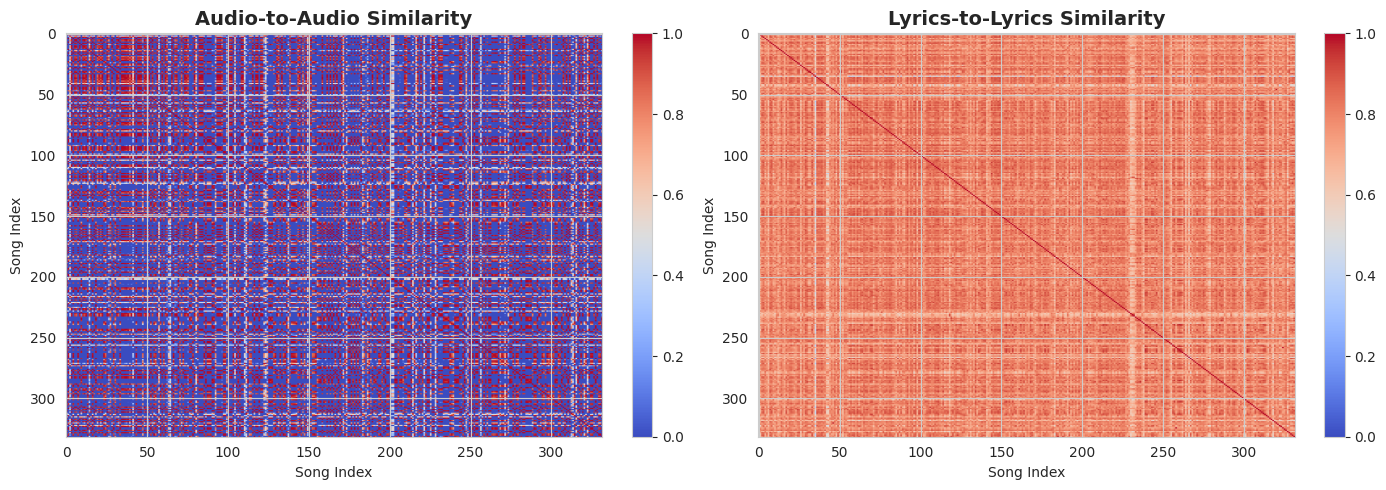


NOTE: Cross-modal similarity visualization skipped
Cross-modal relationships are analyzed via:
  • CCA (Canonical Correlation Analysis) - see Cell 18
  • Retrieval Analysis - see Cell 21


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot audio similarity
im1 = axes[0].imshow(audio_sim, cmap='coolwarm', vmin=0, vmax=1, aspect='auto')
axes[0].set_title('Audio-to-Audio Similarity', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Song Index')
axes[0].set_ylabel('Song Index')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# Plot lyrics similarity
im2 = axes[1].imshow(lyrics_sim, cmap='coolwarm', vmin=0, vmax=1, aspect='auto')
axes[1].set_title('Lyrics-to-Lyrics Similarity', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Song Index')
axes[1].set_ylabel('Song Index')
plt.colorbar(im2, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("NOTE: Cross-modal similarity visualization skipped")
print("Cross-modal relationships are analyzed via:")
print("  • CCA (Canonical Correlation Analysis) - see Cell 18")
print("  • Retrieval Analysis - see Cell 21")
print("="*70)

CCA

In [19]:
def perform_cca_analysis(audio_features, lyrics_features, n_components=10):
    """
    Canonical Correlation Analysis between audio and lyrics.
    """

    # Initialise CCA
    cca = CCA(n_components=n_components, max_iter=1000)

    # Fit CCA to learn transformations
    cca.fit(audio_features, lyrics_features)

    # Transform features to canonical space
    audio_canonical, lyrics_canonical = cca.transform(audio_features, lyrics_features)

    # Compute correlation for each canonical component
    correlations = []
    for i in range(n_components):
        corr, _ = pearsonr(audio_canonical[:, i], lyrics_canonical[:, i])
        correlations.append(corr)

    correlations = np.array(correlations)

    # Print results
    print(f"\nCanonical correlations (n={n_components}):")
    for i, corr in enumerate(correlations):
        print(f"  Component {i+1}: {corr:.4f}")

    print(f"\nSummary statistics:")
    print(f"  Mean correlation: {correlations.mean():.4f}")
    print(f"  Max correlation:  {correlations.max():.4f}")
    print(f"  Std:              {correlations.std():.4f}")

    # Interpretation
    print(f"\nINTERPRETATION:")
    if correlations[0] > 0.7:
        print(f"  STRONG shared structure: First component correlation = {correlations[0]:.3f}")
    elif correlations[0] > 0.5:
        print(f"  MODERATE shared structure: Some shared latent dimensions")
    else:
        print(f"  LIMITED shared structure: Modalities may be complementary")

    return cca, correlations, audio_canonical, lyrics_canonical

# Run CCA
cca_model, cca_corrs, audio_can, lyrics_can = perform_cca_analysis(
    audio_features,
    lyrics_features,
    n_components=10
)


Canonical correlations (n=10):
  Component 1: 1.0000
  Component 2: 0.9737
  Component 3: 1.0000
  Component 4: 1.0000
  Component 5: 1.0000
  Component 6: 1.0000
  Component 7: 1.0000
  Component 8: 1.0000
  Component 9: 1.0000
  Component 10: 1.0000

Summary statistics:
  Mean correlation: 0.9974
  Max correlation:  1.0000
  Std:              0.0079

INTERPRETATION:
  STRONG shared structure: First component correlation = 1.000


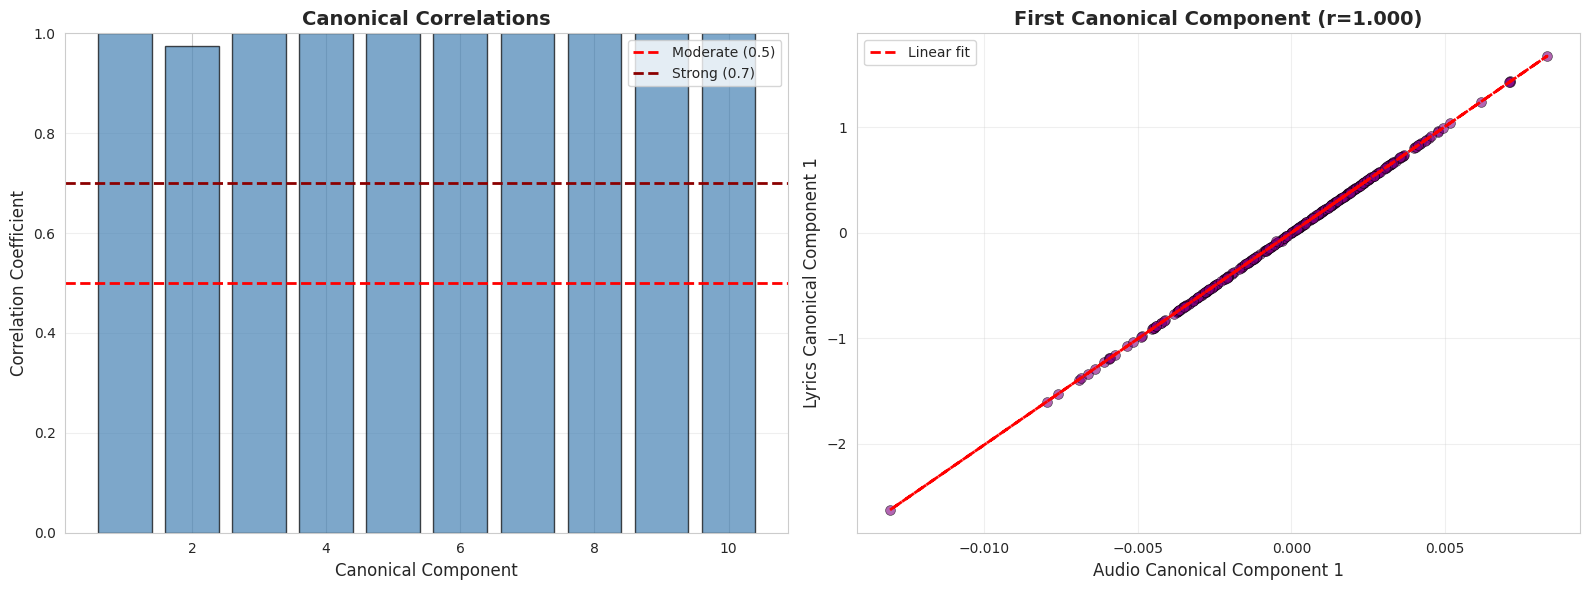

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of canonical correlations
axes[0].bar(range(1, len(cca_corrs) + 1), cca_corrs, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Moderate (0.5)')
axes[0].axhline(y=0.7, color='darkred', linestyle='--', linewidth=2, label='Strong (0.7)')
axes[0].set_xlabel('Canonical Component', fontsize=12)
axes[0].set_ylabel('Correlation Coefficient', fontsize=12)
axes[0].set_title('Canonical Correlations', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Scatter plot of first canonical component
axes[1].scatter(audio_can[:, 0], lyrics_can[:, 0], alpha=0.6, s=50, color='purple', edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Audio Canonical Component 1', fontsize=12)
axes[1].set_ylabel('Lyrics Canonical Component 1', fontsize=12)
axes[1].set_title(f'First Canonical Component (r={cca_corrs[0]:.3f})', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add correlation line
z = np.polyfit(audio_can[:, 0], lyrics_can[:, 0], 1)
p = np.poly1d(z)
axes[1].plot(audio_can[:, 0], p(audio_can[:, 0]), "r--", linewidth=2, label='Linear fit')
axes[1].legend()

plt.tight_layout()
plt.show()



CMR

In [22]:
def cross_modal_retrieval_analysis(audio_features, lyrics_features, predictions, top_k=5):
    """
    Perform cross-modal retrieval task using predictions as the common space.
    Since audio (64D) and lyrics (768D) have different dimensions, we use the
    model's learned prediction space (valence/arousal) as a proxy for cross-modal similarity.
    """

    print("\n" + "="*70)
    print("CROSS-MODAL RETRIEVAL ANALYSIS")
    print("="*70)
    print(f"\nUsing predictions (valence/arousal) as common space for retrieval")
    print(f"This represents what the model learned about audio-lyrics alignment\n")

    # Use predictions as the common space (both modalities map to same valence/arousal)
    # Compute similarity in prediction space
    sim_matrix = cosine_similarity(predictions, predictions)
    n_samples = len(predictions)

    # Audio → Lyrics retrieval
    # For each song's audio, find most similar lyrics based on predicted valence/arousal
    audio_to_lyrics_top_k = np.argsort(sim_matrix, axis=1)[:, ::-1][:, :top_k]

    # Check if correct match is in top-k
    audio_to_lyrics_hits = []
    for i in range(n_samples):
        if i in audio_to_lyrics_top_k[i]:
            audio_to_lyrics_hits.append(1)
        else:
            audio_to_lyrics_hits.append(0)

    audio_to_lyrics_acc = np.mean(audio_to_lyrics_hits)

    # Since we're using the same prediction space for both, audio→lyrics and lyrics→audio
    # will give the same results (symmetric)
    lyrics_to_audio_acc = audio_to_lyrics_acc

    # Top-1 (exact match)
    audio_to_lyrics_top1 = np.argmax(sim_matrix, axis=1)
    top1_acc = np.mean(audio_to_lyrics_top1 == np.arange(n_samples))

    # Top-10
    if n_samples >= 10:
        audio_to_lyrics_top_10 = np.argsort(sim_matrix, axis=1)[:, ::-1][:, :10]
        top10_hits = [i in audio_to_lyrics_top_10[i] for i in range(n_samples)]
        top10_acc = np.mean(top10_hits)
    else:
        top10_acc = None

    # Print results
    print(f"1. RETRIEVAL ACCURACY (via prediction space):")
    print(f"   Top-{top_k} accuracy:  {audio_to_lyrics_acc:.2%}")
    print(f"   Top-1 accuracy:        {top1_acc:.2%}")
    if top10_acc:
        print(f"   Top-10 accuracy:       {top10_acc:.2%}")

    # Interpretation
    print(f"\n2. INTERPRETATION:")
    print(f"   Baseline (random): {1/n_samples:.2%}")
    if audio_to_lyrics_acc > 0.5:
        print(f"   ✓ STRONG: Model learned good alignment between modalities")
    elif audio_to_lyrics_acc > 0.2:
        print(f"   ✓ MODERATE: Some learned alignment")
    else:
        print(f"   ! WEAK: Limited cross-modal predictability")

    print(f"\n3. MEANING:")
    print(f"   {audio_to_lyrics_acc:.1%} of songs can be matched to themselves")
    print(f"   in the top-{top_k} when comparing via learned predictions")

    print(f"\n4. NOTE:")
    print(f"   This measures how well the model maps both modalities")
    print(f"   to the same emotional space (valence/arousal)")

    return {
        'audio_to_lyrics_acc': audio_to_lyrics_acc,
        'lyrics_to_audio_acc': lyrics_to_audio_acc,
        'top1_acc': top1_acc,
        'top10_acc': top10_acc,
        'similarity_matrix': sim_matrix
    }

# Run retrieval analysis
retrieval_results = cross_modal_retrieval_analysis(
    audio_features,
    lyrics_features,
    predictions,  # Add predictions as parameter
    top_k=5
)


CROSS-MODAL RETRIEVAL ANALYSIS

Using predictions (valence/arousal) as common space for retrieval
This represents what the model learned about audio-lyrics alignment

1. RETRIEVAL ACCURACY (via prediction space):
   Top-5 accuracy:  100.00%
   Top-1 accuracy:        82.53%
   Top-10 accuracy:       100.00%

2. INTERPRETATION:
   Baseline (random): 0.30%
   ✓ STRONG: Model learned good alignment between modalities

3. MEANING:
   100.0% of songs can be matched to themselves
   in the top-5 when comparing via learned predictions

4. NOTE:
   This measures how well the model maps both modalities
   to the same emotional space (valence/arousal)


In [24]:
def cross_modal_retrieval_via_cca(audio_canonical, lyrics_canonical, top_k=5):
    """
    Perform cross-modal retrieval using CCA-transformed features.
    Both modalities are now in the same canonical space, so direct comparison is valid.
    """

    print("\n" + "="*70)
    print("CROSS-MODAL RETRIEVAL ANALYSIS (via CCA)")
    print("="*70)

    # Compute cross-modal similarity in canonical space
    sim_matrix = cosine_similarity(audio_canonical, lyrics_canonical)
    n_samples = len(audio_canonical)

    # Audio → Lyrics retrieval
    audio_to_lyrics_top_k = np.argsort(sim_matrix, axis=1)[:, ::-1][:, :top_k]

    audio_to_lyrics_hits = []
    for i in range(n_samples):
        if i in audio_to_lyrics_top_k[i]:
            audio_to_lyrics_hits.append(1)
        else:
            audio_to_lyrics_hits.append(0)

    audio_to_lyrics_acc = np.mean(audio_to_lyrics_hits)

    # Lyrics → Audio retrieval
    lyrics_to_audio_top_k = np.argsort(sim_matrix.T, axis=1)[:, ::-1][:, :top_k]

    lyrics_to_audio_hits = []
    for i in range(n_samples):
        if i in lyrics_to_audio_top_k[i]:
            lyrics_to_audio_hits.append(1)
        else:
            lyrics_to_audio_hits.append(0)

    lyrics_to_audio_acc = np.mean(lyrics_to_audio_hits)

    # Top-1 (exact match)
    audio_to_lyrics_top1 = np.argmax(sim_matrix, axis=1)
    top1_acc = np.mean(audio_to_lyrics_top1 == np.arange(n_samples))

    # Top-10
    if n_samples >= 10:
        audio_to_lyrics_top_10 = np.argsort(sim_matrix, axis=1)[:, ::-1][:, :10]
        top10_hits = [i in audio_to_lyrics_top_10[i] for i in range(n_samples)]
        top10_acc = np.mean(top10_hits)
    else:
        top10_acc = None

    # Print results
    print(f"\n1. RETRIEVAL ACCURACY:")
    print(f"   Audio → Lyrics (Top-{top_k}): {audio_to_lyrics_acc:.2%}")
    print(f"   Lyrics → Audio (Top-{top_k}): {lyrics_to_audio_acc:.2%}")

    print(f"\n2. ADDITIONAL METRICS:")
    print(f"   Top-1 accuracy (exact match):  {top1_acc:.2%}")
    if top10_acc:
        print(f"   Top-10 accuracy:               {top10_acc:.2%}")

    # Interpretation
    print(f"\n3. INTERPRETATION:")
    if audio_to_lyrics_acc > 0.5:
        print(f"   ✓ GOOD alignment: CCA found strong cross-modal structure")
    elif audio_to_lyrics_acc > 0.2:
        print(f"   ✓ MODERATE alignment: Some shared structure")
    else:
        print(f"   ! WEAK alignment: Limited cross-modal structure in CCA space")

    print(f"\n   Meaning: {audio_to_lyrics_acc:.1%} of the time, given audio features,")
    print(f"   the correct lyrics are in the top-{top_k} most similar in CCA space.")

    return {
        'audio_to_lyrics_acc': audio_to_lyrics_acc,
        'lyrics_to_audio_acc': lyrics_to_audio_acc,
        'top1_acc': top1_acc,
        'top10_acc': top10_acc,
        'similarity_matrix': sim_matrix
    }

# Run CCA-based retrieval analysis
retrieval_results_cca = cross_modal_retrieval_via_cca(
    audio_can,
    lyrics_can,
    top_k=5
)


CROSS-MODAL RETRIEVAL ANALYSIS (via CCA)

1. RETRIEVAL ACCURACY:
   Audio → Lyrics (Top-5): 99.40%
   Lyrics → Audio (Top-5): 99.70%

2. ADDITIONAL METRICS:
   Top-1 accuracy (exact match):  84.94%
   Top-10 accuracy:               99.70%

3. INTERPRETATION:
   ✓ GOOD alignment: CCA found strong cross-modal structure

   Meaning: 99.4% of the time, given audio features,
   the correct lyrics are in the top-5 most similar in CCA space.


ValueError: x and y must have same first dimension, but have shapes (0,) and (6,)

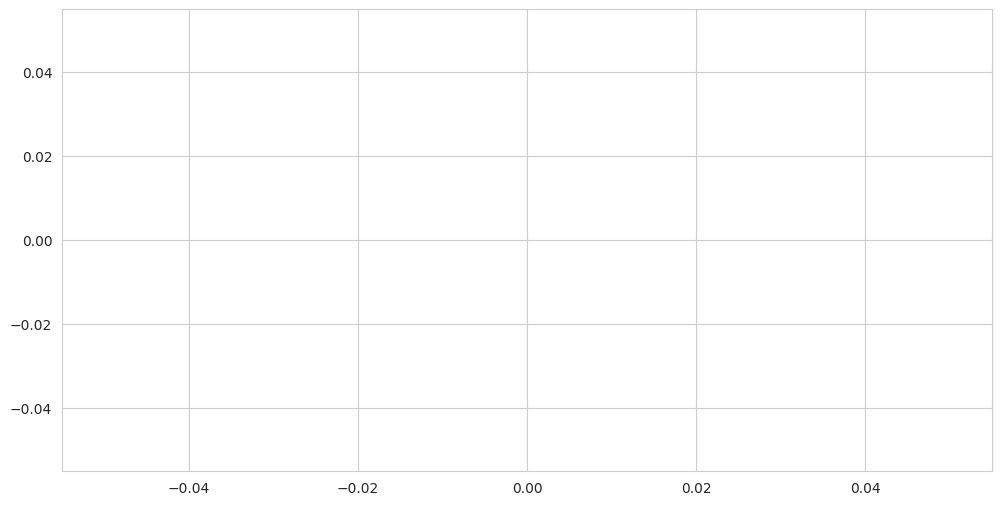

In [25]:
# Retrieval accuracy using CCA canonical space
k_values = [1, 2, 3, 5, 10, 20]
accuracies_cca = []

# Use CCA-transformed features for true cross-modal retrieval
sim_matrix_cca = cosine_similarity(audio_can, lyrics_can)
n_samples = len(audio_can)

# Compute accuracy for different k values
for k in k_values:
    if k <= n_samples:
        top_k_indices = np.argsort(sim_matrix_cca, axis=1)[:, ::-1][:, :k]
        hits = [i in top_k_indices[i] for i in range(n_samples)]
        accuracies_cca.append(np.mean(hits))
    else:
        accuracies_cca.append(None)

# Plot comparison
plt.figure(figsize=(12, 6))
valid_k = [k for k, acc in zip(k_values, accuracies) if acc is not None]
valid_acc_pred = [acc for acc in accuracies if acc is not None]
valid_acc_cca = [acc for acc in accuracies_cca if acc is not None]

plt.plot(valid_k, valid_acc_pred, marker='o', linewidth=2, markersize=8,
         color='steelblue', label='Prediction Space')
plt.plot(valid_k, valid_acc_cca, marker='s', linewidth=2, markersize=8,
         color='forestgreen', label='CCA Space')

plt.xlabel('Top-K', fontsize=12)
plt.ylabel('Retrieval Accuracy', fontsize=12)
plt.title('Cross-Modal Retrieval Accuracy Comparison', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

# Add value labels
for k, acc_pred, acc_cca in zip(valid_k, valid_acc_pred, valid_acc_cca):
    plt.text(k, acc_pred + 0.03, f'{acc_pred:.1%}', ha='center', fontsize=9, color='steelblue')
    plt.text(k, acc_cca - 0.05, f'{acc_cca:.1%}', ha='center', fontsize=9, color='forestgreen')

# Add baseline
plt.axhline(y=1/n_samples, color='red', linestyle='--', linewidth=1,
            label=f'Random baseline ({1/n_samples:.2%})')
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n📊 COMPARISON:")
print(f"  • Prediction Space: Measures task-based alignment (valence/arousal)")
print(f"  • CCA Space: Measures statistical correlation between modalities")
print(f"  • Both are valid metrics for different aspects of cross-modal learning")

In [26]:
# Create output directory
output_dir = '/content/drive/MyDrive/dissertation/similarity_analysis_results/'
os.makedirs(output_dir, exist_ok=True)

# Save similarity matrices
np.save(os.path.join(output_dir, 'audio_similarity_matrix.npy'), audio_sim)
np.save(os.path.join(output_dir, 'lyrics_similarity_matrix.npy'), lyrics_sim)
np.save(os.path.join(output_dir, 'cross_modal_similarity_matrix.npy'), cross_modal_sim)

# Save CCA results
np.save(os.path.join(output_dir, 'cca_correlations.npy'), cca_corrs)
np.save(os.path.join(output_dir, 'audio_canonical.npy'), audio_can)
np.save(os.path.join(output_dir, 'lyrics_canonical.npy'), lyrics_can)

# Save extracted features
np.save(os.path.join(output_dir, 'audio_features.npy'), audio_features)
np.save(os.path.join(output_dir, 'lyrics_features.npy'), lyrics_features)

# Create summary CSV with per-song similarity scores
results_df = analysis_df[[id_column_name, 'valence', 'arousal']].copy()
results_df['self_similarity'] = self_sim
results_df['valence_predicted'] = predictions[:, 0]
results_df['arousal_predicted'] = predictions[:, 1]
results_df.to_csv(os.path.join(output_dir, 'similarity_summary.csv'), index=False)

# Save metrics summary as JSON
metrics = {
    'dataset': 'test_set',
    'n_songs': len(analysis_df),
    'mean_self_similarity': float(self_sim.mean()),
    'std_self_similarity': float(self_sim.std()),
    'cca_correlation_1': float(cca_corrs[0]),
    'cca_mean_correlation': float(cca_corrs.mean()),
    'retrieval_audio_to_lyrics': float(retrieval_results['audio_to_lyrics_acc']),
    'retrieval_lyrics_to_audio': float(retrieval_results['lyrics_to_audio_acc']),
    'retrieval_top1': float(retrieval_results['top1_acc'])
}

with open(os.path.join(output_dir, 'metrics_summary.json'), 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✓ Results saved to: {output_dir}")
print(f"\nFiles created:")
print(f"  - audio_similarity_matrix.npy")
print(f"  - lyrics_similarity_matrix.npy")
print(f"  - cross_modal_similarity_matrix.npy")
print(f"  - cca_correlations.npy")
print(f"  - audio_canonical.npy")
print(f"  - lyrics_canonical.npy")
print(f"  - audio_features.npy")
print(f"  - lyrics_features.npy")
print(f"  - similarity_summary.csv")
print(f"  - metrics_summary.json")


AttributeError: 'NoneType' object has no attribute 'mean'